<h1> Speech Rap Signing Classification</h1>

Source: https://www.youtube.com/watch?v=dOG-HxpbMSw&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=16

Data source: see my SRS_classifier.ipynb notebook

In [1]:
import numpy as np
import json

<h2>Data Preperation</h2>

We use the same MFCC data drawn at 16000 samples per second as we generated for the multi-layer perceptron approach used previously (see SRS_classifier.ipynb).

Data structure:

$x.\texttt{shape}=(\text{num samples},\text{num time intervals}, \text{num MFCC variables})$

$x_i.\texttt{shape} = (\text{num time intervals}, \text{num mfcc variables}))$


$y.\texttt{shape}=(\text{num labels})$

$y_i=\text{label}$

where $\text{label} \in \{1,2,3\}$

In [2]:
#load data from the file
#split data into training and test
"""
load data from a json file with objects "mfcc" and "labels"
@param dataset_path: path to the json file
@return np array of mfcc data, np array of target values
"""
def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)
        inputs=np.array(data["mfcc"])
        targets=np.array(data["labels"])
        return inputs,targets


<h3>Load the data</h3>
Load the data from the jason file and verify that the inputs are of the expected type, and the sample size is as expected, in this case: 480 samples of each label.


In [3]:
x,y = load_data("data.json")
print ("input shape", x.shape)

unique_elements, counts_elements = np.unique(y, return_counts=True)
print("Frequency of unique values of the targets:")
print(np.asarray((unique_elements, counts_elements)))

input shape (1440, 94, 13)
Frequency of unique values of the targets:
[[  1   2   3]
 [480 480 480]]


<h3>Create training, validation and test datasets</h3>
<ul>
    <li><b>training</b>: used to train the model.</li>
    <li><b>validation</b>: used to evaluate the model after training.</li>
    <li><b>test</b>: used to evaluate a model that does well on validation. Ensures that the ML engineer has not been inadvertantly tweaking his model to work on the validation set alone, rather than generalising.</li>
    </ul>
    
Here we also add another axis/dimension to our input, giving each training sample a channel depth of 1. (Our CNN will require 3D samples as input). Our labels do not change.

In [4]:
from sklearn.model_selection import train_test_split
def prepare_datasets(x,y,test_size,validation_size,dataset_path):
    #test set: test on the fully trained model
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_size)
    #validation: test on unseen data, but model may end up learning it as we tweak to maximise validation accuracy
    x_train,x_validation,y_train,y_validation=train_test_split(x_train,y_train,test_size=validation_size)
    x_train=x_train[...,np.newaxis]
    x_validation=x_validation[...,np.newaxis]
    x_test=x_test[...,np.newaxis]
    return x_train,x_test,y_train,y_test, x_validation, y_validation  

Data structure:

$x_{train}.\texttt{shape}=(\text{num samples},\text{num time intervals}, \text{num MFCC variables},\text{depth})$

$x_{validate}.\texttt{shape}=(\text{num samples},\text{num time intervals}, \text{num MFCC variables},\text{depth})$

$x_{test}.\texttt{shape}=(\text{num samples},\text{num time intervals}, \text{num MFCC variables},\text{depth})$



Where $\text{depth}=1$

In [5]:
x_train,x_test,y_train,y_test, x_validation, y_validation = prepare_datasets(x,y,0.25,0.2, "data.json")

In [6]:
#(num samples, num intervals, num variables, num channels)
x_train.shape

(864, 94, 13, 1)

<h2>Model Design</h2>
For this model, I opt for a traditional CNN design: three pooled convolutional layers, followed by a single fully connected layer and an output layer, implemented in Tensorflow's Keras environment.

In [9]:
import tensorflow.keras as keras
"""
Creates a model of three pooled convolutional layers, followed by a single fully connected layer and an output layer.
@param input_shape: the structure of SINGLE value x_i (omits the first dimension of x which is the total number of samples.)
@return uncompiled keras model of the CNN.
"""
def build_model(input_shape,dropoutRate=0):
    model=keras.Sequential()
    #CONV LAYER 1
    model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2), padding='same'))
    #Batch normalisation: process that normalises the activations in the current layer for output to the next layer.
    #Speeds up training (faster convergence) and reliability.
    model.add(keras.layers.BatchNormalization())

    #CONV LAYER 2
    model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization())   

    #CONV LAYER 3
    # we shrink the kernal size
    model.add(keras.layers.Conv2D(filters=32,kernel_size=(2,2),activation="relu", input_shape=input_shape))
    model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='same'))
    model.add(keras.layers.BatchNormalization()) 

    #flatten into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64,activation="relu"))
    model.add(keras.layers.Dropout(dropoutRate))  
    
    #output layer
    #a fully connected layer for classification
    NUMBEROFPOSSIBLEOUTPUTS=4
    model.add(keras.layers.Dense(NUMBEROFPOSSIBLEOUTPUTS,activation='softmax'))
    
    return model

In [10]:
#each sample has the shape (n,130,13,1) <- (num samples,intervals,variables,channels)
input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])
model = build_model(input_shape,dropoutRate=0.4)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 92, 11, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 1, 32)         4

<h3>Compiling the model</h3>
<ul><b>Optimizer</b>: Adam</ul>
<ul><b>Loss Function</b>: sparse_categorical_crossentropy - a powerful tool for categorization tasks.</ul>
<ul><b>Metrics</b>: accuracy</ul>

In [11]:
#Adam is a very very effecting sgd variant for deep learning
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#put all the components together
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"]
              )

<h2>Training the Model</h2>
We fit the model to our training data and validate it against our validation data.

In [12]:
#stores the progression of several metrics as the model trains.
history = model.fit(x_train,y_train,validation_data=(x_validation,y_validation),epochs=50)

Epoch 1/50
27/27 [==============================] - 0s 13ms/step - loss: 1.6341 - accuracy: 0.3889 - val_loss: 1.4392 - val_accuracy: 0.3102
Epoch 2/50
27/27 [==============================] - 0s 10ms/step - loss: 1.2850 - accuracy: 0.4780 - val_loss: 1.3768 - val_accuracy: 0.3148
Epoch 3/50
27/27 [==============================] - 0s 9ms/step - loss: 1.0031 - accuracy: 0.5868 - val_loss: 1.3127 - val_accuracy: 0.3380
Epoch 4/50
27/27 [==============================] - 0s 10ms/step - loss: 0.8118 - accuracy: 0.6725 - val_loss: 1.2061 - val_accuracy: 0.3935
Epoch 5/50
27/27 [==============================] - 0s 9ms/step - loss: 0.6880 - accuracy: 0.7465 - val_loss: 1.0781 - val_accuracy: 0.4537
Epoch 6/50
27/27 [==============================] - 0s 10ms/step - loss: 0.5973 - accuracy: 0.7604 - val_loss: 0.9078 - val_accuracy: 0.5880
Epoch 7/50
27/27 [==============================] - 0s 10ms/step - loss: 0.5373 - accuracy: 0.7975 - val_loss: 0.7434 - val_accuracy: 0.7130
Epoch 8/50
27/2

<h2>Evaluating the Trained Model</h2>
We plot the history of the model across epochs with respect to accuracy and error using the $\texttt{plot_history(...)}$ function provided by Valerio Velardo in 

https://www.youtube.com/watch?v=_xcFAiufwd0&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=13

In [13]:
import matplotlib.pyplot as plt
"""
https://www.youtube.com/watch?v=_xcFAiufwd0&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=13
Plot the history of the model across epochs with respect to accuracy and error as two subplots.
@param history: a history produced by a model.fit function of a keras model.
"""
def plot_history(history):
    fig,axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"],label="train accuracy")
    axs[0].plot(history.history["val_accuracy"],label="test accuracy")
    axs[0].set_ylabel("accuracy")
    #loc sets location
    axs[0].legend(loc="lower right")
    axs[0].set_title("accuracy eval")
    
    axs[1].plot(history.history["loss"],label="train error")
    axs[1].plot(history.history["val_loss"],label="test error")
    axs[1].set_ylabel("error")
    #loc sets location
    axs[1].legend(loc="upper right")
    axs[1].set_title("error eval")
    axs[1].set_xlabel("error")
    axs[1].set_xlabel("epoch")
    
    #just keeps the images from overlapping
    fig.tight_layout() 
    #plt.show()

It is clear that the model has trained well and consistently achieves accuracy above $97 \%$ on the validation set. It seems to converge to this value after about 20 epochs.

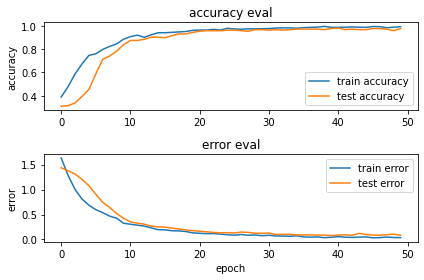

In [14]:
plot_history(history)

A simple prediction function.

In [15]:
"""
see whether the model makes  the correct prediction about a sample
@param x_n: the input mfcc data
@param y_n: the true label of the data
@param cats: the text representation of the output categories
@return a string describing the prediction and the actual label of x_n
"""
def predict(x_n, y_n,cats):
    #predict expects a batch of values as input.
    # it should be the first value in x_n.shape
    x_n=x_n[np.newaxis,...]
    prediction = np.argmax(model.predict(x_n))
    predictionAsString=cats[prediction-1]
    textPrediction = "We predict:{}\nActual answer is:{}".format(predictionAsString,cats[y_n-1])
    return textPrediction
sampleNum = int(np.random.rand()*x_test.shape[0])
print ("Testing Sample Number ",sampleNum)
x_n=x_test[sampleNum]
y_n=y_test[sampleNum]

cats =  ['speech','rap','singing','failure']
print(predict(x_n,y_n,cats))

 

Testing Sample Number  102
We predict:rap
Actual answer is:rap
